In [1]:
# CONFIGURATION - Change these to select the metric and varied parameter
METRIC = 'test/accuracy'  # Options: 'test/accuracy', 'test/auroc', 'test/precision', 'test/recall', etc.
VARIED_PARAMETER = 'homophily_range'  # Options: 'homophily_range', 'avg_degree_range', etc.

In [2]:
import wandb
import pandas as pd

api = wandb.Api(timeout=100)

# Get all runs from a project
runs = api.runs("graphuniverse/final_homophily_experiments")

# Collect data from all runs
all_data = []
for run in runs:
    # Get summary metrics (your current columns)
    summary = run.summary._json_dict
    summary['run_name'] = run.name
    summary['run_id'] = run.id
    
    # Add config parameters with 'config_' prefix to avoid name conflicts
    config = run.config
    for key, value in config.items():
        summary[f'config_{key}'] = value
    
    all_data.append(summary)

# Convert to DataFrame and save
df = pd.DataFrame(all_data)

/home/gbg141/.conda/envs/tb/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
import json

# Function to safely extract nested values
def safe_get_nested(obj, keys, default=None):
    """Safely get nested dictionary values"""
    try:
        for key in keys:
            obj = obj[key]
        return obj
    except (KeyError, TypeError, IndexError):
        return default

def dict_to_sorted_string(d):
    """Convert nested dict to consistent sorted string"""
    if d is None:
        return "None"
    return json.dumps(d, sort_keys=True, separators=(',', ':'))

# Create string representations for sorting
df['generation_params_str'] = df['config_dataset'].apply(
    lambda x: dict_to_sorted_string(safe_get_nested(x, ['loader', 'parameters', 'generation_parameters']))
)

df['model_name'] = df['config_model'].apply(
    lambda x: safe_get_nested(x, ['model_name'])
)

# Sort by generation parameters first, then model name second (keeps ALL columns)
df_sorted = df.sort_values(['generation_params_str', 'model_name'])

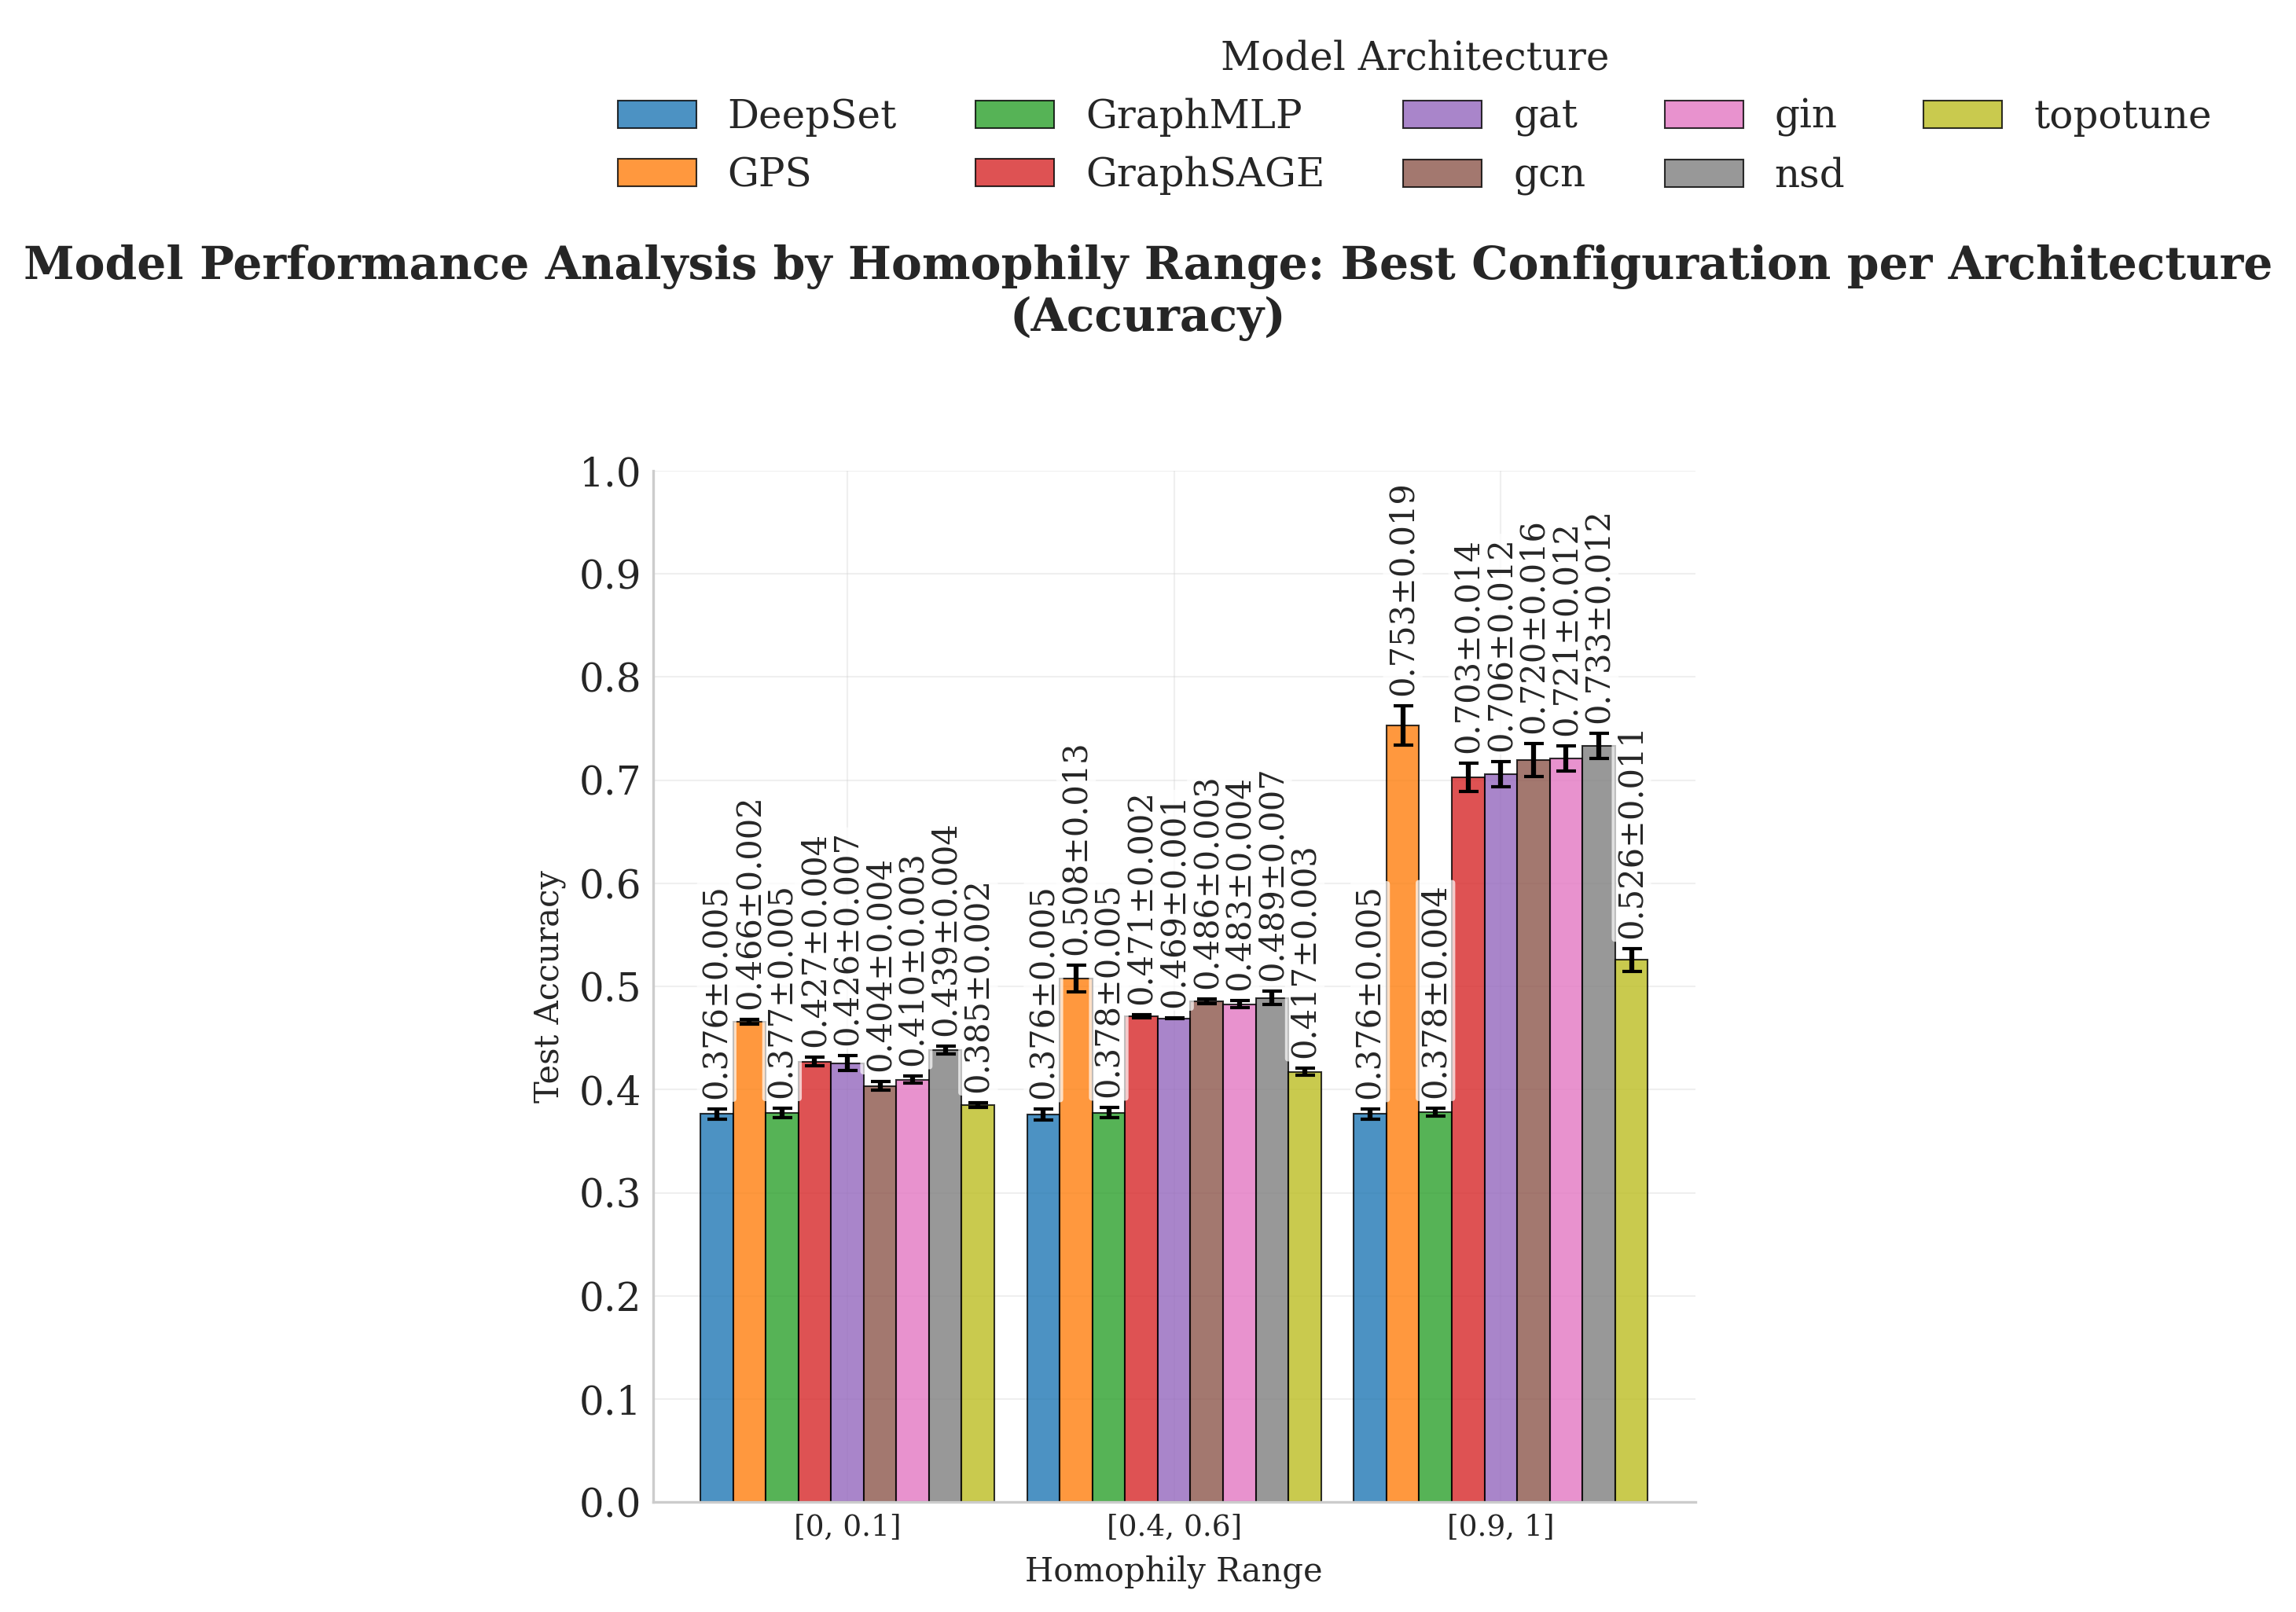

Analyzing metric: test/accuracy
Varied parameter: homophily_range
Data availability by subplot:

N = 1000:
  homophily_range = (0, 0.1): ['DeepSet', 'GPS', 'GraphMLP', 'GraphSAGE', 'gat', 'gcn', 'gin', 'nsd', 'topotune']
  homophily_range = (0.4, 0.6): ['DeepSet', 'GPS', 'GraphMLP', 'GraphSAGE', 'gat', 'gcn', 'gin', 'nsd', 'topotune']
  homophily_range = (0.9, 1): ['DeepSet', 'GPS', 'GraphMLP', 'GraphSAGE', 'gat', 'gcn', 'gin', 'nsd', 'topotune']
Saved 27 homophily_range results to homophily_range_results.json


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import json
from itertools import product
import pandas as pd

# Set publication style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'axes.linewidth': 0.8,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linewidth': 0.5,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'errorbar.capsize': 3,
    'figure.dpi': 300
})

def dict_to_sorted_string_no_seed(d, seed_keys=['seed', 'random_seed', 'random_state']):
    """Convert nested dict to consistent sorted string, excluding seed-related keys"""
    if d is None:
        return "None"
    
    def remove_seeds(obj):
        if isinstance(obj, dict):
            return {k: remove_seeds(v) for k, v in obj.items() if k not in seed_keys}
        elif isinstance(obj, list):
            return [remove_seeds(item) for item in obj]
        else:
            return obj
    
    cleaned_dict = remove_seeds(d)
    return json.dumps(cleaned_dict, sort_keys=True, separators=(',', ':'))

# Create model config strings WITHOUT random seeds
df_sorted['model_config_str'] = df_sorted['config_model'].apply(
    lambda x: dict_to_sorted_string_no_seed(x)
)

# Filter out rows with missing essential data
df_clean = df_sorted.dropna(subset=['generation_params_str', 'model_config_str', METRIC])
df_clean = df_clean[df_clean['generation_params_str'] != "None"]

# Extract parameters (now configurable)
def extract_params(gen_params_str, varied_param):
    try:
        parsed = json.loads(gen_params_str)
        n_graphs = parsed['family_parameters']['n_graphs']
        varied_param_value = tuple(parsed['family_parameters'][varied_param])
        return n_graphs, varied_param_value
    except:
        return None, None

df_clean[['n_graphs', VARIED_PARAMETER]] = df_clean['generation_params_str'].apply(
    lambda x: pd.Series(extract_params(x, VARIED_PARAMETER))
)

df_clean = df_clean.dropna(subset=['n_graphs', VARIED_PARAMETER])

# Get unique values
unique_n_graphs = sorted(df_clean['n_graphs'].unique())
unique_varied_param_values = sorted(df_clean[VARIED_PARAMETER].unique())
unique_models = sorted(df_clean['model_name'].unique())

# Create consistent color mapping for models
model_colors = {model: f'C{i}' for i, model in enumerate(unique_models)}

# Prepare data structure for grouped bar plot
results_matrix = {}
for n_graphs, varied_param_value in product(unique_n_graphs, unique_varied_param_values):
    subset = df_clean[
        (df_clean['n_graphs'] == n_graphs) & 
        (df_clean[VARIED_PARAMETER] == varied_param_value)
    ]
    
    if len(subset) > 0:
        # Calculate statistics per model configuration
        stats_per_model_config = subset.groupby(['model_name', 'model_config_str'])[METRIC].agg(['mean', 'std', 'count']).reset_index()
        stats_per_model_config['std'] = stats_per_model_config['std'].fillna(0)
        
        # Get best configuration per model type
        if len(stats_per_model_config) > 0:
            best_per_model_type = stats_per_model_config.loc[
                stats_per_model_config.groupby('model_name')['mean'].idxmax()
            ]
            
            for _, row in best_per_model_type.iterrows():
                key = (n_graphs, varied_param_value, row['model_name'])
                results_matrix[key] = (row['mean'], row['std'])

# Create figure with subplots
fig, axes = plt.subplots(1, len(unique_n_graphs), figsize=(5*len(unique_n_graphs), 6))

# Handle case with only one subplot
if len(unique_n_graphs) == 1:
    axes = [axes]

# For each N value (subplot)
for subplot_idx, n_graphs in enumerate(unique_n_graphs):
    ax = axes[subplot_idx]
    
    # Generate x-axis positions for grouped bars within this subplot
    n_varied_param_combinations = len(unique_varied_param_values)
    n_models = len(unique_models)
    bar_width = 0.08
    group_spacing = 0.8
    x_positions = np.arange(n_varied_param_combinations) * group_spacing
    
    # Create group labels (varied parameter ranges)
    group_labels = []
    for varied_param_value in unique_varied_param_values:
        param_str = f"[{varied_param_value[0]}, {varied_param_value[1]}]"
        group_labels.append(param_str)
    
    # Plot bars for each model
    for model_idx, model in enumerate(unique_models):
        means = []
        stds = []
        
        for varied_param_value in unique_varied_param_values:
            key = (n_graphs, varied_param_value, model)
            if key in results_matrix:
                mean_val, std_val = results_matrix[key]
                means.append(mean_val)
                stds.append(std_val)
            else:
                means.append(0)  # No data
                stds.append(0)
        
        # Calculate x positions for this model's bars
        x_model = x_positions + (model_idx - n_models/2 + 0.5) * bar_width
        
        # Plot bars (only add label for legend purposes)
        bars = ax.bar(x_model, means, bar_width, 
                     yerr=stds, capsize=3,
                     label=model,
                     color=model_colors[model], 
                     alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Add value annotations
        for bar, mean_val, std_val in zip(bars, means, stds):
            if mean_val > 0:  # Only annotate if there's data
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std_val + 0.01,
                       f'{mean_val:.3f}±{std_val:.3f}', 
                       ha='center', va='bottom', fontsize=10, rotation=90,
                       bbox=dict(boxstyle="round,pad=0.1", facecolor='white', alpha=0.7, edgecolor='none'))
    
    # Customize each subplot
    # ax.set_title(f'$N_{{graphs}} = {int(n_graphs)}$', fontsize=12, fontweight='bold', pad=15)
    
    # Create a nice label for the varied parameter
    param_label = VARIED_PARAMETER.replace('_', ' ').title().replace('Range', 'Range')
    ax.set_xlabel(param_label, fontsize=10)
    
    # Only show y-label for leftmost subplot
    if subplot_idx == 0:
        metric_label = METRIC.replace('test/', '').replace('_', ' ').title()
        ax.set_ylabel(f'Test {metric_label}', fontsize=10)
    
    # Set x-axis
    ax.set_xticks(x_positions)
    ax.set_xticklabels(group_labels, fontsize=9)
    
    # Set y-axis
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    
    # Add grid
    ax.grid(True, alpha=0.3, axis='y')

# Create metric name for title
metric_name = METRIC.replace('test/', '').replace('_', ' ').title()
param_name = VARIED_PARAMETER.replace('_', ' ').title()

# Add overall title with more space
fig.suptitle(f'Model Performance Analysis by {param_name}: Best Configuration per Architecture\n({metric_name})', 
             fontsize=14, fontweight='bold', y=0.98)

# Add legend at top left of entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Model Architecture', 
          loc='upper left', bbox_to_anchor=(0.02, 1.15), fontsize=12, ncols = 5)

# Remove individual legends from subplots
for ax in axes:
    ax.legend().set_visible(False)

# Adjust layout with more top margin
plt.tight_layout()
plt.subplots_adjust(top=0.82, left=0.08)

# Save as high-quality figure (optional)
# plt.savefig(f'model_performance_by_n_graphs_{METRIC.replace("/", "_")}_{VARIED_PARAMETER}.pdf', dpi=300, bbox_inches='tight')
# plt.savefig(f'model_performance_by_n_graphs_{METRIC.replace("/", "_")}_{VARIED_PARAMETER}.png', dpi=300, bbox_inches='tight')

plt.show()

# Reset style
plt.rcdefaults()

# Print summary
print(f"Analyzing metric: {METRIC}")
print(f"Varied parameter: {VARIED_PARAMETER}")
print("Data availability by subplot:")
for n_graphs in unique_n_graphs:
    print(f"\nN = {n_graphs}:")
    for varied_param_value in unique_varied_param_values:
        available_models = []
        for model in unique_models:
            key = (n_graphs, varied_param_value, model)
            if key in results_matrix:
                available_models.append(model)
        print(f"  {VARIED_PARAMETER} = {varied_param_value}: {available_models}")

# Save results for visualization
param_results = {}
for n_graphs, varied_param_value, model in results_matrix.keys():
    # Create a key that matches the expected format for the visualization
    json_key = f"{varied_param_value}_{model}"
    
    # Only save if this combination hasn't been saved yet (avoid duplicates)
    if json_key not in param_results:
        param_results[json_key] = {
            VARIED_PARAMETER: varied_param_value,
            'model': model,
            'mean': results_matrix[(n_graphs, varied_param_value, model)][0],
            'std': results_matrix[(n_graphs, varied_param_value, model)][1]
        }

# Save to JSON with parameter name in filename
output_filename = f'{VARIED_PARAMETER}_results.json'
with open(output_filename, 'w') as f:
    json.dump(param_results, f, indent=2)

print(f"Saved {len(param_results)} {VARIED_PARAMETER} results to {output_filename}")